In [1]:
# pandas for data cleaning and inspection
import pandas as pd
# numpy for various functionality
import numpy as np
# seaborn for data inspection by visualization
import seaborn as sns
# json for converting json data
import json
from pandas.io.json import json_normalize
import os
# sklearn for subsampling
from sklearn.cluster import KMeans
#from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

# Cluster Data to Subsample
The following method seeks to subsample by clustering the data over the following features:

* device.browser
* device.deviceCategory
* device.isMobile
* device.operatingSystem
* device.geoNetwork.country
* totals.transactionRevenue (only available in training data set)
* new.ReturningCustomer (created by determining if customer returns)

This requires loading in these features then converting nominal features to vectors then running a clustering algorithm and sampling a constant amount from each cluster that provides the desired volumne reduction. 

Note: It might also be good to consider the following features when clustering and subsampling:

* date

In [2]:
# Initialize names of files to save for checkpointing and subsampling
fname_checkpoint_rows = '11142019_checkpoint_rows_train_subs.csv'
fname_checkpoint_returning_labels = '11142019_checkpoint_returning_labels_train_subs.csv'
fname_subsampled_data = '11142019_train_subsampled.csv'

In [3]:
def load_df(csv_path='train_v2.csv', nrows=None, keep_cols=None, keep_json_cols=None, chunksize=10000):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    # Alternate approach where we load in chunks of full file then trim chunks and combine
    iter_csv = pd.read_csv(csv_path, # Read data set
                           converters={column: json.loads for column in JSON_COLUMNS}, 
                           dtype={'fullVisitorId': 'str'}, # Set datatype to fullVisitorId to string
                           iterator=True, # Iterate over csv file since very large data
                           chunksize=chunksize, # Set size of chunks loaded by iterator
                           nrows=nrows
                          )
    
    chunk_list = []
    for chunk in iter_csv:
        ##print(chunk.shape)
        ##print(chunk.index)
        ##print("chunk[0]: ", chunk.iloc[0])
        chunk_index = chunk.index
        # Set chunk with JSON_COLUMNS
        json_chunk = chunk[JSON_COLUMNS]
        if keep_cols != None:
            # Only keep wanted columns
            chunk = chunk[keep_cols]
        #print("left_on =", left_on)
        for column in JSON_COLUMNS:
            column_as_df = json_normalize(json_chunk[column])
            ##print("Column_as_df[0]: ", column_as_df.iloc[0])
            column_as_df.columns = ["{}.{}".format(column, subcolumn) for subcolumn in column_as_df.columns]
            ##print("Column_as_df[0]: ", column_as_df.iloc[0])
            # Only keep columns of interest
            if keep_json_cols != None:
                new_cols = [col for col in list(column_as_df.columns.values) if col in keep_json_cols]
                column_as_df = column_as_df[new_cols]
            ##print("chunk[0]: ", chunk.iloc[0])
            ##print("Column_as_df[0]: ", column_as_df.iloc[0])
            ##print(column_as_df.index)
            # Change column_as_df index to index of chunk for join to work
            column_as_df.index = chunk_index
            ##print(column_as_df.index)
            ##print("After drop: ", chunk.shape)
            # Check if resulting column_as_df is nonempty
            ##print(len(column_as_df.columns))
            if len(column_as_df.columns) != 0:
                chunk = chunk.join(column_as_df)
                ##print("After merge: ", chunk.shape)
        ##print("Loaded {}. Shape: {}".format(os.path.basename(csv_path),chunk.shape))
        chunk_list += [chunk]
        
    ##print(len(chunk_list))
    ##for chunk in chunk_list:
    ##    print(chunk.shape)
    df = pd.concat(chunk_list)
    return df

In [4]:
keep_cols = [u'fullVisitorId'] #, u'device.browser', u'device.deviceCategory', u'device.isMobile', u'device.operatingSystem'] #, 'geoNetwork.country']
keep_json_cols = [u'device.browser', 
                  u'device.deviceCategory', 
                  u'device.isMobile', 
                  u'device.operatingSystem', 
                  u'geoNetwork.country',
                  u'totals.transactionRevenue']
#fVId_df = load_df(nrows=2000, chunksize=1000, csv_path='train_v2.csv', keep_cols=keep_cols, keep_json_cols=keep_json_cols)
fVId_df = load_df(chunksize=10000, csv_path='train_v2.csv', keep_cols=keep_cols, keep_json_cols=keep_json_cols)
fVId_df.head()

,fullVisitorId,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.country,totals.transactionRevenue
0,3162355547410993243,Firefox,desktop,False,Windows,Germany,NaN
1,8934116514970143966,Chrome,desktop,False,Chrome OS,United States,NaN
2,7992466427990357681,Chrome,mobile,True,Android,United States,NaN
3,9075655783635761930,Chrome,desktop,False,Windows,Turkey,NaN
4,6960673291025684308,Chrome,desktop,False,Windows,Mexico,NaN


In [5]:
# Create new feature that specifies customers who have returned to GStore
# Identify indices of customers who returned to GStore
returningCustomer_indices = fVId_df[fVId_df['fullVisitorId'].duplicated(keep=False)].index.values
returningCustomer_indices
# For each index in returningCustomer_indices add 1 to new.returningCustomer otherwise add 0
fVId_df['new.returningCustomer'] = 0
fVId_df.at[returningCustomer_indices, 'new.returningCustomer'] = 1
# View updates
fVId_df.head()
#fVId_df[fVId_df['new.returningCustomer'] == 1].head()

,fullVisitorId,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.country,totals.transactionRevenue,new.returningCustomer
0,3162355547410993243,Firefox,desktop,False,Windows,Germany,NaN,0
1,8934116514970143966,Chrome,desktop,False,Chrome OS,United States,NaN,1
2,7992466427990357681,Chrome,mobile,True,Android,United States,NaN,0
3,9075655783635761930,Chrome,desktop,False,Windows,Turkey,NaN,0
4,6960673291025684308,Chrome,desktop,False,Windows,Mexico,NaN,0


In [6]:
# Convert all NaN values in transactionRevenue to 0
fVId_df = fVId_df.fillna(0)
fVId_df.head()
fVId_df.dtypes

fullVisitorId                object
device.browser               object
device.deviceCategory        object
device.isMobile                bool
device.operatingSystem       object
geoNetwork.country           object
totals.transactionRevenue    object
new.returningCustomer         int64
dtype: object

In [7]:
# Set list of all features considered to be categorical
cat_features = keep_json_cols
cat_features.remove(u'totals.transactionRevenue')
# Convert certain columns to categorical dtype
fVId_df[cat_features] = fVId_df[cat_features].astype('category')
#fVId_df['device.browser'] = fVId_df['device.browser'].astype('category')
# Convert categorical columns to integers
cat_columns = fVId_df.select_dtypes(['category']).columns
fVId_df[cat_columns] = fVId_df[cat_columns].apply(lambda x: x.cat.codes)
# View updates
fVId_df.head()

,fullVisitorId,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.country,totals.transactionRevenue,new.returningCustomer
0,3162355547410993243,43,0,0,20,75,0,0
1,8934116514970143966,35,0,0,3,218,0,1
2,7992466427990357681,35,1,1,1,218,0,0
3,9075655783635761930,35,0,0,20,210,0,0
4,6960673291025684308,35,0,0,20,132,0,0


In [8]:
# Perform min max normalization of categorical data
fVId_df[cat_columns] = (fVId_df[cat_columns] - fVId_df[cat_columns].min())/(fVId_df[cat_columns].max() - fVId_df[cat_columns].min())
# Perform min max nromalization of transaction revenue data
fVId_df['totals.transactionRevenue'] = fVId_df['totals.transactionRevenue'].astype(float)
fVId_df['totals.transactionRevenue'] = (fVId_df['totals.transactionRevenue'] - fVId_df['totals.transactionRevenue'].min())/(fVId_df['totals.transactionRevenue'].max() - fVId_df['totals.transactionRevenue'].min())
# Preview normalized data
fVId_df.head()

,fullVisitorId,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.country,totals.transactionRevenue,new.returningCustomer
0,3162355547410993243,0.335938,0.0,0.0,0.869565,0.330396,0.0,0
1,8934116514970143966,0.273438,0.0,0.0,0.130435,0.960352,0.0,1
2,7992466427990357681,0.273438,0.5,1.0,0.043478,0.960352,0.0,0
3,9075655783635761930,0.273438,0.0,0.0,0.869565,0.925110,0.0,0
4,6960673291025684308,0.273438,0.0,0.0,0.869565,0.581498,0.0,0


In [9]:
# Cluster non-returning customer data using sklearn.cluster.KMeans
X_onetime_df = fVId_df[fVId_df['new.returningCustomer'] == 0].drop(columns=['fullVisitorId'])
X_returning_df = fVId_df[fVId_df['new.returningCustomer'] == 1].drop(columns=['fullVisitorId'])
kmeans_onetime = KMeans(n_clusters=5, random_state=0).fit(X_onetime_df)
kmeans_returning = KMeans(n_clusters=5, random_state=0).fit(X_returning_df)
# View cluster information
print(kmeans_onetime.labels_)
print(kmeans_returning.labels_)

[4 2 0 ... 0 2 2]
[1 1 2 ... 2 4 0]


In [10]:
onetime_indices = X_onetime_df.index.values
returning_indices = X_returning_df.index.values

In [21]:
# Specify reduction of file size from subsampling
reduction_frac = 0.75 # Results in 1 Gb training and 0.5 Gb testing
# Perform stratified sampling using labels from KMeans clustering
skf = StratifiedShuffleSplit(n_splits=1, train_size=reduction_frac)

# Alternate approach (not using)
#fVId_df_train, fVId_df_test, fVId_df_1, fVId_df_2 = train_test_split(fVId_df, kmeans.labels_, stratify=kmeans.labels_, test_size=0.75)
# View rows of data to be sampled
#fVId_df_1

# Perform stratified sampling of onetime customers
for train, test in skf.split(X_onetime_df, kmeans_onetime.labels_):
    onetime_labels_1 = sorted(list(train))
    onetime_labels_2 = sorted(list(test))
# Set list of index values from original set using subsampled labels
onetime_indices_subsample = []
for i in onetime_labels_1:
    onetime_indices_subsample.append(onetime_indices[i])
# View index values of data to be sampled
print(onetime_indices_subsample)

# Perform stratified sampling of returning customers
for train, test in skf.split(X_returning_df, kmeans_returning.labels_):
    returning_labels_1 = sorted(list(train))
    returning_labels_2 = sorted(list(test))
# Set list of index values from original set using subsampled labels
returning_indices_subsample = []
for i in returning_labels_1:
    returning_indices_subsample.append(returning_indices[i])
# View index values of data to be sampled
print(returning_indices_subsample)

# Combine labels into single list
fVId_df_subsample_labels = sorted(onetime_indices_subsample + returning_indices_subsample)
print(fVId_df_subsample_labels)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
print("Number of onetime customers in sampling..: %d\n"
      "Number of returning customers in sampling: %d\n"
      %(len(onetime_indices_subsample), len(returning_indices_subsample))
     )

Number of onetime customers in sampling..: 853536
Number of returning customers in sampling: 427716



In [27]:
fVId_df_subsample_labels

[0,
 1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 14,
 17,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 34,
 36,
 37,
 38,
 40,
 42,
 43,
 44,
 45,
 47,
 49,
 50,
 52,
 53,
 54,
 57,
 58,
 59,
 62,
 64,
 65,
 66,
 67,
 68,
 70,
 71,
 74,
 75,
 76,
 77,
 79,
 81,
 82,
 83,
 84,
 85,
 86,
 88,
 89,
 90,
 91,
 93,
 97,
 98,
 99,
 100,
 104,
 106,
 107,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 124,
 125,
 127,
 130,
 131,
 132,
 133,
 134,
 136,
 137,
 138,
 139,
 140,
 141,
 144,
 145,
 147,
 148,
 150,
 151,
 152,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 177,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 192,
 193,
 194,
 195,
 196,
 198,
 199,
 202,
 203,
 204,
 205,
 206,
 207,
 209,
 210,
 211,
 213,
 215,
 216,
 217,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 229,
 230,
 232,
 234,
 235,
 236,
 237,
 239,
 240,
 241,
 242,
 244,

In [25]:
onetime_indices_subsample

[0,
 3,
 4,
 6,
 7,
 8,
 10,
 11,
 12,
 14,
 17,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 30,
 34,
 36,
 38,
 40,
 43,
 44,
 47,
 49,
 50,
 52,
 53,
 54,
 62,
 64,
 65,
 66,
 68,
 70,
 74,
 75,
 76,
 77,
 79,
 81,
 82,
 83,
 84,
 85,
 86,
 88,
 89,
 90,
 91,
 93,
 97,
 100,
 106,
 109,
 111,
 112,
 113,
 115,
 116,
 117,
 120,
 124,
 125,
 127,
 131,
 132,
 133,
 134,
 136,
 138,
 140,
 141,
 144,
 145,
 147,
 148,
 150,
 151,
 152,
 154,
 155,
 156,
 157,
 158,
 159,
 162,
 163,
 167,
 168,
 170,
 171,
 173,
 174,
 177,
 180,
 183,
 189,
 190,
 192,
 194,
 198,
 202,
 203,
 204,
 205,
 206,
 207,
 209,
 210,
 211,
 213,
 215,
 217,
 219,
 220,
 221,
 223,
 224,
 225,
 229,
 230,
 232,
 236,
 239,
 240,
 241,
 242,
 244,
 249,
 253,
 259,
 262,
 268,
 269,
 270,
 274,
 275,
 276,
 280,
 281,
 282,
 285,
 286,
 287,
 290,
 295,
 296,
 297,
 308,
 309,
 316,
 320,
 321,
 322,
 323,
 324,
 325,
 329,
 330,
 332,
 333,
 334,
 335,
 336,
 338,
 339,
 341,
 342,
 344,
 347,
 353,
 357,
 358,

In [23]:
len(fVId_df_subsample_labels)

1281252

In [24]:
with open('11142019_checkpoint_onetime_labels.txt', 'w') as f:
    for item in onetime_indices_subsample:
        print >> f, item

with open('11142019_checkpoint_returning_labels.txt', 'w') as f:
    for item in returning_indices_subsample:
        print >> f, item

with open('11142019_checkpoint_subsample_labels.txt', 'w') as f:
    for item in fVId_df_subsample_labels:
        print >> f, item

In [12]:
## Save rows to file
#import csv
#
#with open(fname_checkpoint_rows, 'wb') as myfile:
#    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#    wr.writerow(fVId_df_subsample_labels)
#    
#with open(fname_checkpoint_returning_labels, 'wb') as myfile:
#    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#    wr.writerow(returning_labels_1)

In [13]:
def load_subsampled_df(csv_path='train_v2.csv', nrows=None, chunksize=10000, index_list=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    # Alternate approach where we load in chunks of full file then trim chunks and combine
    iter_csv = pd.read_csv(csv_path, # Read data set
                           converters={column: json.loads for column in JSON_COLUMNS}, 
                           dtype={'fullVisitorId': 'str'}, # Set datatype to fullVisitorId to string
                           iterator=True, # Iterate over csv file since very large data
                           chunksize=chunksize, # Set size of chunks loaded by iterator
                           nrows=nrows
                          )
    # Convert index_list to set for intersections later
    index_set = set(index_list)
    # Initialize chunk_list
    chunk_list = []
    for chunk in iter_csv:
        ##print(chunk.shape)
        ##print(chunk.index)
        chunk_index = chunk.index
        # Only keep rows with specified indices
        if index_list != None:
            # Intersect current chunk indices with user index set
            new_indices = sorted(list(index_set.intersection(set(chunk_index))))
            ##print(new_indices)
            # Only keep rows in new_indices list
            ##print(chunk.index)
            chunk = chunk.loc[new_indices]
        # Add chunk to chunk_list
        chunk_list += [chunk]
        
    ##print(len(chunk_list))
    ##for chunk in chunk_list:
    ##    print(chunk.shape)
    df = pd.concat(chunk_list)
    return df

In [3]:
def load_subsampled_df(csv_path='train_v2.csv', nrows=None, chunksize=4000, index_list=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    # Alternate approach where we load in chunks of full file then trim chunks and combine
    iter_csv = pd.read_csv(csv_path, # Read data set
                           converters={column: json.loads for column in JSON_COLUMNS}, 
                           dtype={'fullVisitorId': 'str'}, # Set datatype to fullVisitorId to string
                           iterator=True, # Iterate over csv file since very large data
                           chunksize=chunksize, # Set size of chunks loaded by iterator
                           nrows=nrows
                          )
    # Convert index_list to set for intersections later
    index_set = set(index_list)
    # Initialize chunk_list
    chunk_list = []
    for chunk in iter_csv:
        ##print(chunk.shape)
        ##print(chunk.index)
        chunk_index = chunk.index
        for column in JSON_COLUMNS:
            column_as_df = json_normalize(chunk[column])
            ##print("Column_as_df[0]: ", column_as_df.iloc[0])
            column_as_df.columns = ["{}.{}".format(column, subcolumn) for subcolumn in column_as_df.columns]
            # Change column_as_df index to index of chunk for join to work
            column_as_df.index = chunk_index
            chunk = chunk.join(column_as_df)
        #print(chunk)
        # Drop 'hits', 'customDimensions', and JSON columns
        keep_cols = list(chunk.columns.values)
        drop_list = JSON_COLUMNS + ['hits', 'customDimensions']
        # Also drop columns with 'not available in demo dataset'
        drop_list += ['device.browserSize', 
                      'device.browserVersion', 
                      'device.flashVersion', 
                      'device.language', 
                      'device.mobileDeviceBranding',
                      'device.mobileDeviceInfo',
                      'device.mobileDeviceMarketingName',
                      'device.mobileDeviceModel',
                      'device.mobileInputSelector',
                      'device.operatingSystemVersion',
                      'device.screenColors',
                      'device.screenResolution']
        for word in drop_list:
            keep_cols.remove(word)
        # Only keep wanted columns
        chunk = chunk[keep_cols]
        # Only keep rows with specified indices
        if index_list != None:
            # Intersect current chunk indices with user index set
            new_indices = sorted(list(index_set.intersection(set(chunk_index))))
            ##print(new_indices)
            # Only keep rows in new_indices list
            ##print(chunk.index)
            chunk = chunk.loc[new_indices]
        # Add chunk to chunk_list
        chunk_list += [chunk]
        
    ##print(len(chunk_list))
    ##for chunk in chunk_list:
    ##    print(chunk.shape)
    df = pd.concat(chunk_list)
    return df

### Load checkpointed data (index values for subsampling)

In [4]:
with open('11132019_checkpoint_subsample_labels.txt') as f:
    loaded_subsample_labels = f.read().splitlines()
with open('11132019_checkpoint_returning_labels.txt') as f:
    loaded_returning_labels = f.read().splitlines()
#with open('11142019_checkpoint_onetime_labels.txt') as f:
#    loaded_onetime_labels = f.read().splitlines()
    
fVId_df_subsample_labels = loaded_subsample_labels
fVId_df_subsample_labels = map(int, fVId_df_subsample_labels)
returning_indices_subsample = loaded_returning_labels
returning_indices_subsample = map(int, returning_indices_subsample)

In [5]:
#returning_indices_subsample
fVId_df_subsample_labels

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 29,
 30,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 52,
 54,
 55,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 69,
 70,
 71,
 72,
 73,
 74,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 89,
 90,
 91,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 107,
 108,
 109,
 110,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 171,
 172,
 173,
 174,
 175,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,


In [6]:
#import csv
#with open('11132019_checkpoint_rows_train_subs-47percentreturning.csv', 'rb') as f:
#    reader = csv.reader(f)
#    fVId_df_subsample_labels_loaded = list(reader)

#fVId_df_subsample_labels_loaded = fVId_df_subsample_labels_loaded[0]
#fVId_df_subsample_labels_loaded = fVId_df_subsample_labels_loaded[::2]
#fVId_df_subsample_labels_loaded = map(int, fVId_df_subsample_labels_loaded)
#len(fVId_df_subsample_labels_loaded)

In [5]:
# Reload train set but only rows indicated by subsampling
#new_fVId_df = load_subsampled_df(csv_path="train_v2.csv", nrows = 2000, chunksize=1000, index_list=fVId_df_subsample_labels)
#new_fVId_df = load_subsampled_df(csv_path="train_v2.csv", index_list=range(100000), nrows = 100000)
new_fVId_df = load_subsampled_df(csv_path="train_v2.csv", index_list=fVId_df_subsample_labels)
new_fVId_df.head()

/home/james/.local/lib/python2.7/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,channelGrouping,date,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,fullVisitorId,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,...,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitId,visitNumber,visitStartTime
1,Referral,20171016,Chrome,desktop,False,Chrome OS,8934116514970143966,Cupertino,not available in demo dataset,Americas,...,(not set),NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,1508176307,6,1508176307
2,Direct,20171016,Chrome,mobile,True,Android,7992466427990357681,not available in demo dataset,not available in demo dataset,Americas,...,(not set),NaN,True,NaN,(none),NaN,(direct),1508201613,1,1508201613
3,Organic Search,20171016,Chrome,desktop,False,Windows,9075655783635761930,not available in demo dataset,not available in demo dataset,Asia,...,(not set),NaN,NaN,(not provided),organic,NaN,google,1508169851,1,1508169851
4,Organic Search,20171016,Chrome,desktop,False,Windows,6960673291025684308,not available in demo dataset,not available in demo dataset,Americas,...,(not set),NaN,NaN,(not provided),organic,NaN,google,1508190552,1,1508190552
5,Referral,20171016,Chrome,desktop,False,Macintosh,0166277907528479249,San Francisco,not available in demo dataset,Americas,...,(not set),NaN,NaN,NaN,(none),/offer/2145,(direct),1508196701,1,1508196701


In [6]:
# Create new feature that specifies customers who have returned to GStore
# Specify indices of customers who returned to GStore
returningCustomer_indices = returning_indices_subsample
# For each index in returningCustomer_indices add 1 to new.returningCustomer otherwise add 0
new_fVId_df['new.returningCustomer'] = 0
new_fVId_df.at[returningCustomer_indices, 'new.returningCustomer'] = 1
# View updates
new_fVId_df.head()
#new_fVId_df[new_fVId_df['new.returningCustomer'] == 1].head()

,channelGrouping,date,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,fullVisitorId,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,...,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitId,visitNumber,visitStartTime,new.returningCustomer
1,Referral,20171016,Chrome,desktop,False,Chrome OS,8934116514970143966,Cupertino,not available in demo dataset,Americas,...,NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,1508176307,6,1508176307,1
2,Direct,20171016,Chrome,mobile,True,Android,7992466427990357681,not available in demo dataset,not available in demo dataset,Americas,...,NaN,True,NaN,(none),NaN,(direct),1508201613,1,1508201613,0
3,Organic Search,20171016,Chrome,desktop,False,Windows,9075655783635761930,not available in demo dataset,not available in demo dataset,Asia,...,NaN,NaN,(not provided),organic,NaN,google,1508169851,1,1508169851,0
4,Organic Search,20171016,Chrome,desktop,False,Windows,6960673291025684308,not available in demo dataset,not available in demo dataset,Americas,...,NaN,NaN,(not provided),organic,NaN,google,1508190552,1,1508190552,0
5,Referral,20171016,Chrome,desktop,False,Macintosh,0166277907528479249,San Francisco,not available in demo dataset,Americas,...,NaN,NaN,NaN,(none),/offer/2145,(direct),1508196701,1,1508196701,1


In [7]:
# Drop json columns
#new_fVId_df = new_fVId_df.drop(['customDimensions', 'device', 'totals', 'hits', 'trafficSource', 'geoNetwork'], axis = 1)
#new_fVId_df = new_fVId_df.drop(['customDimensions', 'device', 'totals', 'hits', 'trafficSource', 'geoNetwork'], axis = 1)

In [8]:
new_fVId_df.shape

(1537503, 47)

In [ ]:
# Check that percentage of returning customers is close to original set
n_returning_original = fVId_df[fVId_df['new.returningCustomer'] == 1].shape[0]
original_returning = float(n_returning_original)/float(fVId_df.shape[0])
n_returning_sampled = new_fVId_df[new_fVId_df['new.returningCustomer'] == 1].shape[0]
sampled_returning = float(n_returning_sampled)/float(new_fVId_df.shape[0])
print("Number of returning customers in full data set.......: %lg\n"
      "Number of returning customers in sampled data set....: %lg\n\n"
      "Percentage of returning customers in full data set...: %lg\n"
      "Percentage of returning customers in sampled data set: %lg" 
      %(n_returning_original, n_returning_sampled, 100 * original_returning, 100 * sampled_returning)
     )

In [9]:
# Export new dataframe to csv file (NOTE: has train in filename)
new_fVId_df.to_csv(fname_subsampled_data, # File name
                   index=False, # Prevent extra index clumn from being saved in csv file
                   encoding='utf-8'
                  )

### Testing the subsampled set is loading correctly

In [22]:
#j = pd.read_csv(fname_subsampled_data)
j = pd.read_csv(fname_subsampled_data, dtype={'fullVisitorId': 'str'})
j.head()

,channelGrouping,date,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,...,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitId,visitNumber,visitStartTime,new.returningCustomer
0,Organic Search,20171016,Safari,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,...,NaN,NaN,(not provided),organic,NaN,google,1508177658,1,1508177658,0
1,Organic Search,20171016,Safari,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,NaN,NaN,(not provided),organic,NaN,google,1508197277,1,1508197277,0
2,Organic Search,20171016,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,NaN,NaN,(not provided),organic,NaN,google,1508167897,1,1508167897,0
3,Paid Search,20171016,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,...,NaN,NaN,6qEhsCssdK0z36ri,cpc,NaN,google,1508196731,1,1508196731,1
4,Organic Search,20171016,Safari,not available in demo dataset,not available in demo dataset,tablet,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,...,NaN,NaN,(not provided),organic,NaN,google,1508162542,1,1508162542,1


In [24]:
j.dtypes
#j.shape

channelGrouping                                       object
date                                                   int64
device.browser                                        object
device.browserSize                                    object
device.browserVersion                                 object
device.deviceCategory                                 object
device.flashVersion                                   object
device.isMobile                                       object
device.language                                       object
device.mobileDeviceBranding                           object
device.mobileDeviceInfo                               object
device.mobileDeviceMarketingName                      object
device.mobileDeviceModel                              object
device.mobileInputSelector                            object
device.operatingSystem                                object
device.operatingSystemVersion                         object
device.screenColors     

# Older Code (Data Investigation)

# Load fullVisitorId Values from Test Data
First, we load only the fullVisitorId values from the test data set to inspect the number of times customers shop at the GStore. We only load the fullVisitorId feature as the data set is very large and we do not need other values at the moment.

In [2]:
fVId_df = pd.read_csv("test_v2.csv", # Read test data set
                      usecols=["fullVisitorId"], # Only read Ids to save space
                      dtype={'fullVisitorId': 'str'} # Datatype of Ids should be string
                     )

In [3]:
# Print out head of fullVisitorId test data
fVId_df.head()

,fullVisitorId
0,7460955084541987166
1,460252456180441002
2,3461808543879602873
3,975129477712150630
4,8381672768065729990


# Examine Details of fullVisitorId Values
Here we use the fullVisitorId values to determine the number of unique shoppers at the GStore, key values for the data set, and a distribution of the data.

In [4]:
# Determine number of unique fullVisitorIds compared to entire length of test set
# TODO: Fix Percentage of Customers that return, currently incorrect
n_unique = fVId_df.nunique()
n_total = fVId_df.shape[0]
# Print values 
print("Number of unique fullVisitorId values in test data....: %d\n"
      "Total number of entries in test set...................: %d\n"
      %(n_unique, n_total)
     )

Number of unique fullVisitorId values in test data....: 296530
Total number of entries in test set...................: 401589
Percentage of customers that return after one purchase: 26



In [5]:
# Count number of occurrences of each fullVisitorId
fVId_df_counts_series = fVId_df["fullVisitorId"].value_counts()

In [6]:
# Get key statistics for number of duplicate appearances of fullVisitorId values
fVId_df_counts_series.describe()

count    296530.000000
mean          1.354295
std           1.316748
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         105.000000
Name: fullVisitorId, dtype: float64

In [7]:
# Extract number of appearances of each fullVisitorId as list
fVId_count_list = [fVId_df_counts_series[i] for i in range(len(fVId_df_counts_series))]

Number of bins: 105



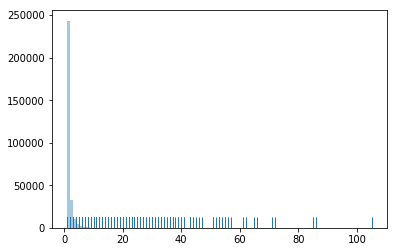

In [8]:
# Generate histogram from repeated fullVisitorId values
n_bins = max(fVId_count_list) - min(fVId_count_list) + 1
print("Number of bins: %d\n" %(n_bins))
sns.distplot(fVId_count_list, bins=n_bins, kde=False, rug=True)

# Save fullVisitorId Counts to CSV File
Here we convert the series data to a DataFrame with the fullVisitorId values and Counts then save the resulting DataFrame to a csv file for later use. This is so that we can import the number of counts of each fullVisitorId to external projects without having to preprocess during those projects.

In [9]:
# Convert the pd.series to pd.dataframe
fVId_df_counts = pd.DataFrame({'fullVisitorId':fVId_df_counts_series.index, 'fullVisitorId_Count':fVId_df_counts_series.values})
# Export number of counts to csv file (NOTE: has test in filename)
fVId_df_counts.to_csv("test_fullVisitorId_counts.csv", # File name
                      index=False # Prevent extra index clumn from being saved in csv file
                     )
# Print head of resulting DataFrame here
fVId_df_counts.head()

,fullVisitorId,fullVisitorId_Count
0,0650107116874202739,105
1,7706472452740899006,86
2,7282998257608986241,85
3,6246006502985590876,72
4,8801084265240272984,71


In [10]:
# Reload the saved data from csv file to check that it worked correctly
test_load_csv = pd.read_csv("test_fullVisitorId_counts.csv")
test_load_csv.head()

,fullVisitorId,fullVisitorId_Count
0,0650107116874202739,105
1,7706472452740899006,86
2,7282998257608986241,85
3,6246006502985590876,72
4,8801084265240272984,71


# Subsampling to Create Toy Data Set
Here we subsample the data to create a toy data set that people can start working with. In subsampling, we try to maintain properties that the full data set possesses (like distribution, mean, IQR, etc). We will subsample 1 out of every 100 values to reduce the data set from ~8gb to ~80mb.

In [11]:
# Factor by which to reduce data size
reduce_factor = 100
# Subsample counts
sub_fVId_counts = fVId_df_counts_series.iloc[reduce_factor/2::reduce_factor]
# Print head of subsampled data
sub_fVId_counts.head()

5115382610109354163    35
2277575183321823043    20
2444418098923394768    16
9087584523494817971    14
4674089143124380237    13
Name: fullVisitorId, dtype: int64

In [12]:
# Inspect subsampled data to check if it still has desired properties
sub_fVId_counts.describe()

count    2965.000000
mean        1.352445
std         1.241258
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        35.000000
Name: fullVisitorId, dtype: float64

In [13]:
# Convert the pd.series to pd.dataframe
sub_fVId_df_counts = pd.DataFrame({'fullVisitorId':sub_fVId_counts.index, 'fullVisitorId_Count':sub_fVId_counts.values})
# Export number of counts to csv file (NOTE: has test in filename)
#sub_fVId_df_counts.to_csv("toy_fullVisitorId_counts.csv", # File name
#                          index=False # Prevent extra index clumn from being saved in csv file
#                         )
# Print head of resulting DataFrame here
sub_fVId_df_counts.head()

,fullVisitorId,fullVisitorId_Count
0,5115382610109354163,35
1,2277575183321823043,20
2,2444418098923394768,16
3,9087584523494817971,14
4,4674089143124380237,13


In [14]:
# Determine number of unique fullVisitorIds compared to entire length of test set
sub_n_unique = sub_fVId_df_counts[sub_fVId_df_counts.fullVisitorId_Count > 1].shape[0]
sub_n_total = sub_fVId_df_counts["fullVisitorId"].shape[0]
sub_frac_returning = float(sub_n_unique)/float(sub_n_total)
# Print values 
print("Number of customers returning after one purchase......: %d\n"
      "Total number of entries in test set...................: %d\n"
      "Percentage of customers that return after one purchase: %d\n"
      %(sub_n_unique, sub_n_total, 100 * sub_frac_returning)
     )

Number of customers returning after one purchase......: 531
Total number of entries in test set...................: 2965
Percentage of customers that return after one purchase: 17



In [15]:
# Use fullVisitorId values from subsampled DataFrame to get indices of these fullVisitorId values in original DataFrame
sub_index_list = fVId_df[fVId_df['fullVisitorId'].isin(sub_fVId_df_counts["fullVisitorId"].tolist())].index.values
# Print list of indices
sub_index_list

array([   213,    343,    357, ..., 401439, 401449, 401499])

In [16]:
# Save list of all fullVisitorId values in subsampled data set
sub_list = sub_fVId_df_counts["fullVisitorId"].tolist()

In [17]:
# Alternate approach where we load in chunks of full file then trim chunks and combine
iter_csv = pd.read_csv("test_v2.csv", # Read test data set
                       dtype={'fullVisitorId': 'str'}, # Set datatype to fullVisitorId to string
                       iterator=True, # Iterate over csv file since very large data
                       chunksize=10000 # Set size of chunks loaded by iterator
                      )
df = pd.concat([chunk[chunk['fullVisitorId'].isin(sub_list)] for chunk in iter_csv])

In [18]:
df.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
213,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20180511,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8579656825990360142,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '18',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""10"", ""pageviews"": ""9""...","{""referralPath"": ""(not set)"", ""campaign"": ""(no...",1526088307,1,1526088307
343,Organic Search,[],20180511,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6601952600535996711,"{""continent"": ""Asia"", ""subContinent"": ""Southea...","[{'hitNumber': '1', 'time': '0', 'hour': '8', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""15"", ""pageviews"": ""8""...","{""referralPath"": ""(not set)"", ""campaign"": ""(no...",1526054322,1,1526054322
357,Organic Search,[],20180511,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",7287974372135096138,"{""continent"": ""Europe"", ""subContinent"": ""North...","[{'hitNumber': '1', 'time': '0', 'hour': '12',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""15"", ""pageviews"": ""14...","{""referralPath"": ""(not set)"", ""campaign"": ""(no...",1526067603,1,1526067603
428,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7726982755871027292,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '7', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""21"", ""pageviews"": ""16...","{""referralPath"": ""(not set)"", ""campaign"": ""(no...",1526049361,1,1526049361
494,Referral,"[{'index': '4', 'value': 'North America'}]",20180511,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6640516667197207102,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '16',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""30"", ""pageviews"": ""25...","{""referralPath"": ""/"", ""campaign"": ""(not set)"",...",1526082436,1,1526082436


# Investigating Returning Customers
Here we look through the duplicate fullVisitorId values to examine key statistics for returning customers. here we are interested in determining information such as the average number of times a returning customer visits the GStore and the distribution of this data.

In [19]:
# Identify duplicate fullVisitorId values
# Note: Setting keep=False so all duplicates are preserved (none removed)
fVId_dupl_df = fVId_df[fVId_df.duplicated(keep=False)] 

In [20]:
# Print out head of duplicate fullVisitorId data from test set
fVId_dupl_df.head()

,fullVisitorId
0,7460955084541987166
1,460252456180441002
2,3461808543879602873
3,975129477712150630
5,2866297766347322467


In [21]:
# Get row indices of duplicates in test set
fVId_dupl_df.index.values

array([     0,      1,      2, ..., 401585, 401586, 401587])

In [22]:
# Count number of occurrences of each fullVisitorId
# Note: Setting sort=False prevents value_counts from sorting on number of occurrences
# Note: Check value_counts() documentation for other options (such as binning)
fVId_dupl_counts = fVId_dupl_df["fullVisitorId"].value_counts() #sort=False)
# Print counts of duplicates
fVId_dupl_counts

0650107116874202739    105
7706472452740899006     86
7282998257608986241     85
6246006502985590876     72
8801084265240272984     71
3394365851070256556     66
4371234797809848128     65
1957458976293878100     62
3812322643136728251     61
8294474757414328531     57
6714534128082027149     56
4930101516600649997     55
7176224214701641059     55
4291568253495154853     55
0580285152007136822     54
0390089942503107796     53
6937432852498495114     53
5604431401052990973     53
9249130983722228273     53
8665078014499866389     52
104301799180690557      51
547810491476877409      51
4099631678878053818     47
3576926539813461824     46
7816703500640932658     45
356205740595976603      44
820169660719458037      44
1823544410201173301     43
6466133506999069433     43
1240303467547542136     43
                      ... 
5063773192053454219      2
2824603225497510985      2
0331097142180656989      2
00217190245033763        2
4902910033923709401      2
398312120463391662       2
5

In [23]:
# Get key statistics for number of duplicate appearances of fullVisitorId values
fVId_dupl_counts.describe()

count    53062.000000
mean         2.979929
std          2.543756
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max        105.000000
Name: fullVisitorId, dtype: float64

These key statistics indicate that most returning customers in the data set shop at the GStore between 2 and 3 times. There are outliers that shop many more times which are illustrated in the histogram plot a few cells below.

In [24]:
# Extract number of appearances of each fullVisitorId as list
fVId_dupl_count_list = [fVId_dupl_counts[i] for i in range(len(fVId_dupl_counts))]

Number of bins: 104



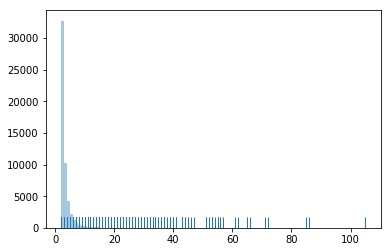

In [25]:
# Generate histogram from repeated fullVisitorId values
n_bins = max(fVId_dupl_count_list) - min(fVId_dupl_count_list) + 1
print("Number of bins: %d\n" %(n_bins))
sns.distplot(fVId_dupl_count_list, bins=n_bins, kde=False, rug=True)

Histogram indicates that the number of visits by recurring GStore customers recorded to unique fullVisitorId values are primarily concentrated between 2 and 20 visits with the largest concentration being in the first bin (2 visits)

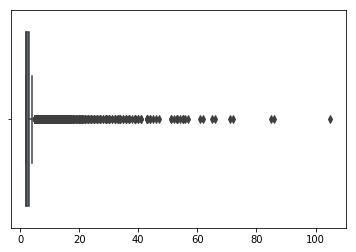

In [26]:
# Generate boxplot of duplicated fullVisitorId data
sns.boxplot(fVId_dupl_count_list)

In [35]:
def load_df(csv_path='train_v2.csv', nrows=None, json_cols=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        if json_cols == None:
            column_as_df.columns = ["{}.{}".format(column, subcolumn) for subcolumn in column_as_df.columns]
        else:
            column_as_df.columns = json_cols
        print(column_as_df.columns)
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print("Loaded {}. Shape: {}".format(os.path.basename(csv_path),df.shape))
    return df

In [156]:
def load_df(csv_path='train_v2.csv', nrows=None, keep_cols=None, chunksize=10000):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    # Alternate approach where we load in chunks of full file then trim chunks and combine
    iter_csv = pd.read_csv(csv_path, # Read data set
                           converters={column: json.loads for column in JSON_COLUMNS}, 
                           dtype={'fullVisitorId': 'str'}, # Set datatype to fullVisitorId to string
                           iterator=True, # Iterate over csv file since very large data
                           chunksize=chunksize, # Set size of chunks loaded by iterator
                           nrows=nrows
                          )
    chunk_list = []
    for chunk in iter_csv:
        print(chunk.shape)
        for column in JSON_COLUMNS:
            column_as_df = json_normalize(chunk[column])
            column_as_df.columns = ["{}.{}".format(column, subcolumn) for subcolumn in column_as_df.columns]
            print(column_as_df.columns)
            chunk = chunk.drop(column, axis=1)
            print("After drop: ", chunk.shape)
            chunk = chunk.merge(column_as_df, right_index=True, left_index=True)
            print("After merge: ", chunk.shape)
        print("Loaded {}. Shape: {}".format(os.path.basename(csv_path),chunk.shape))
        #print(list(chunk.columns.values))
        if keep_cols != None:
            chunk = chunk[keep_cols]
        chunk_list += [chunk]
        
    #chunk_list = [chunk for chunk in iter_csv]
    print(len(chunk_list))
    for chunk in chunk_list:
        print(chunk.shape)
    df = pd.concat(chunk_list)
    return df

In [157]:
keep_cols = [u'fullVisitorId', u'device.browser', u'device.deviceCategory', u'device.isMobile', u'device.operatingSystem'] #, 'geoNetwork.country']
fVId_df = load_df(nrows=300, chunksize=150, csv_path='test_v2.csv',keep_cols=keep_cols) #, json_cols=json_cols)

(150, 13)
Index([u'device.browser', u'device.browserSize', u'device.browserVersion',
       u'device.deviceCategory', u'device.flashVersion', u'device.isMobile',
       u'device.language', u'device.mobileDeviceBranding',
       u'device.mobileDeviceInfo', u'device.mobileDeviceMarketingName',
       u'device.mobileDeviceModel', u'device.mobileInputSelector',
       u'device.operatingSystem', u'device.operatingSystemVersion',
       u'device.screenColors', u'device.screenResolution'],
      dtype='object')
('After drop: ', (150, 12))
('After merge: ', (150, 28))
Index([u'geoNetwork.city', u'geoNetwork.cityId', u'geoNetwork.continent',
       u'geoNetwork.country', u'geoNetwork.latitude', u'geoNetwork.longitude',
       u'geoNetwork.metro', u'geoNetwork.networkDomain',
       u'geoNetwork.networkLocation', u'geoNetwork.region',
       u'geoNetwork.subContinent'],
      dtype='object')
('After drop: ', (150, 27))
('After merge: ', (150, 38))
Index([u'totals.hits', u'totals.newVisits', u'to

In [158]:
fVId_df.shape

(150, 5)

In [120]:
fVId_df

,fullVisitorId,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem
0,7460955084541987166,Chrome,mobile,True,Android
1,460252456180441002,Chrome,desktop,False,Macintosh
2,3461808543879602873,Chrome,desktop,False,Chrome OS
3,975129477712150630,Chrome,mobile,True,iOS
4,8381672768065729990,Internet Explorer,tablet,True,Windows
5,2866297766347322467,Chrome,desktop,False,Windows
6,2235365487897339889,Chrome,mobile,True,Android
7,1303090465617023038,Chrome,desktop,False,Macintosh
8,0459669224143241747,Safari (in-app),tablet,True,iOS
9,589440789980446309,Edge,desktop,False,Windows


In [121]:
fVId_df.shape

(200, 5)